In [1]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

path = "./Auxiliary_DCGAN_WGAN_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
# test = ICLEVRLoader("./", mode="test")

batch_size = 128 # based on paper
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
test_labels = data
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        test_labels[i][j] = obj[test_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[test_labels[i]] = 1
    test_labels[i] = tmp
test_labels = torch.tensor(test_labels).to(device)

> Found 18009 images...


In [3]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(n_classes+latent_dim, 128)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( 128, img_shape*8 , 4, 1, 0, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(gen_input).view(-1, 128, 1, 1)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(3, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
#             nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )
        
        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False), 
#             nn.Sigmoid()
        )
        self.aux_layer = nn.Sequential(
            nn.Linear(img_shape * 8 * 4 * 4, self.n_classes), 
            nn.Sigmoid()
        )

    def forward(self, img):
        # Concatenate label embedding and image to produce input
#         labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
#         d_in = torch.cat((img, labels), 1)
        out = self.main(img)

        validity = self.adv_layer(out).view(-1, 1)
        label = self.aux_layer(out.view(out.shape[0], -1))

        return validity, label

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
load = False
if load:
    generator = torch.load("./Auxiliary_DCGAN_WGANGP_generator_epoch550.pt", map_location=device)
    discriminator = torch.load("./Auxiliary_DCGAN_WGANGP_discriminator_epoch550.pt", map_location=device)
else:
    generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
    discriminator = Discriminator(n_classes, img_shape).to(device)
    generator.apply(weights_init)
    discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
def save_acc(filename, g_loss, d_loss, score):
    try:
        acc = np.load(filename)
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_score = acc['score']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np_score = np.append(np_score, score)
        np.savez(filename, g_loss=np_g_loss, d_loss=np_d_loss, score=np_score)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        score = np.array(score)
        np.savez(filename, g_loss=g_loss, d_loss=d_loss, score=score)
        
def test_eval(generator, epoch):
    np.random.seed(0)    
    generator.eval()
    eval_model = evaluation_model()
    batch_size = test_labels.shape[0]
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
    gen_imgs = generator(z, test_labels) # shape [batch_size, 3, 64, 64]
    if epoch % 10 == 0:
        show_image(gen_imgs)
    return eval_model.eval(gen_imgs, test_labels)

def show_image(gen_imgs):
    # step 1: convert it to [0 ,2]
    gen_imgs = gen_imgs +1
    
    # step 2: convert it to [0 ,1]
    gen_imgs = gen_imgs - gen_imgs.min()
    gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())
    
    grid = make_grid(gen_imgs)
    plt.figure(figsize=(14, 14))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

[Epoch 1/100] [D loss: -70.017913] [G loss: 792.391980] [test score: 0.111111]
[Epoch 2/100] [D loss: -98.851414] [G loss: 1070.024079] [test score: 0.097222]
[Epoch 3/100] [D loss: -70.886051] [G loss: 456.081228] [test score: 0.111111]
[Epoch 4/100] [D loss: -94.503484] [G loss: 1095.975725] [test score: 0.152778]
[Epoch 5/100] [D loss: -53.787843] [G loss: 41.306790] [test score: 0.097222]
[Epoch 6/100] [D loss: -25.190306] [G loss: 512.711947] [test score: 0.125000]
[Epoch 7/100] [D loss: -51.837595] [G loss: 255.329802] [test score: 0.125000]
[Epoch 8/100] [D loss: -62.431773] [G loss: -186.090626] [test score: 0.111111]
[Epoch 9/100] [D loss: -25.433938] [G loss: 106.641907] [test score: 0.125000]


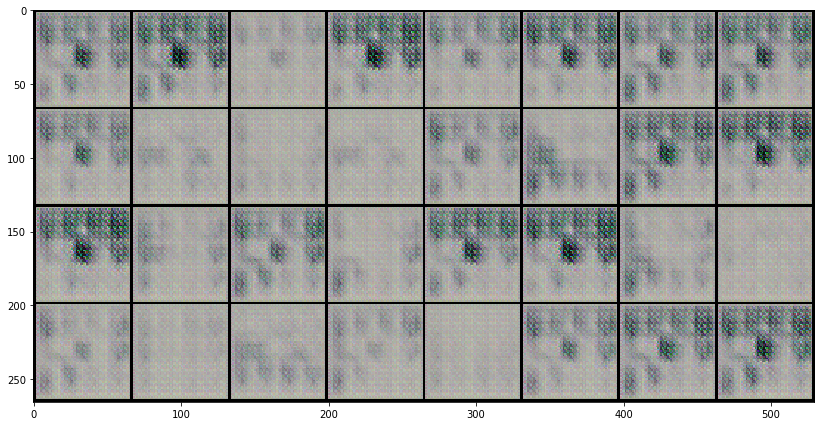

[Epoch 10/100] [D loss: -32.325935] [G loss: 389.342647] [test score: 0.138889]
[Epoch 11/100] [D loss: -116.406178] [G loss: 1311.260480] [test score: 0.125000]
[Epoch 12/100] [D loss: -62.977320] [G loss: 763.849158] [test score: 0.097222]
[Epoch 13/100] [D loss: -89.381278] [G loss: -358.541522] [test score: 0.111111]
[Epoch 14/100] [D loss: -61.902323] [G loss: -161.609966] [test score: 0.138889]
[Epoch 15/100] [D loss: -90.052027] [G loss: 1508.012257] [test score: 0.152778]
[Epoch 16/100] [D loss: 7.343749] [G loss: 1499.367118] [test score: 0.152778]
[Epoch 17/100] [D loss: -4.914738] [G loss: -261.718033] [test score: 0.097222]
[Epoch 18/100] [D loss: -35.354247] [G loss: 234.112409] [test score: 0.111111]
[Epoch 19/100] [D loss: -26.832387] [G loss: 12.408732] [test score: 0.138889]


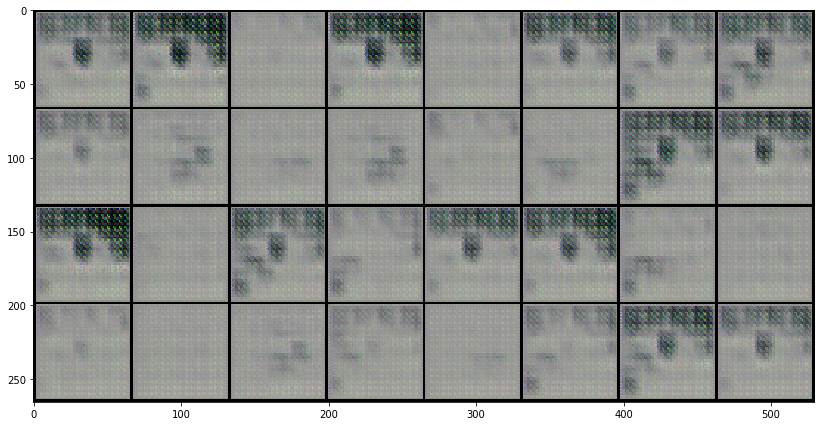

[Epoch 20/100] [D loss: -32.844929] [G loss: 592.296314] [test score: 0.111111]
[Epoch 21/100] [D loss: -32.105258] [G loss: -264.320498] [test score: 0.125000]
[Epoch 22/100] [D loss: -28.947061] [G loss: 472.962175] [test score: 0.111111]
[Epoch 23/100] [D loss: -9.999084] [G loss: 521.916641] [test score: 0.111111]
[Epoch 24/100] [D loss: -29.183026] [G loss: -464.261008] [test score: 0.097222]
[Epoch 25/100] [D loss: -22.413790] [G loss: 12.946427] [test score: 0.125000]
[Epoch 26/100] [D loss: -31.705606] [G loss: 916.984665] [test score: 0.138889]
[Epoch 27/100] [D loss: -1.755776] [G loss: 531.906594] [test score: 0.111111]
[Epoch 28/100] [D loss: 11.401403] [G loss: 133.255437] [test score: 0.111111]
[Epoch 29/100] [D loss: 16.243018] [G loss: 183.052097] [test score: 0.125000]


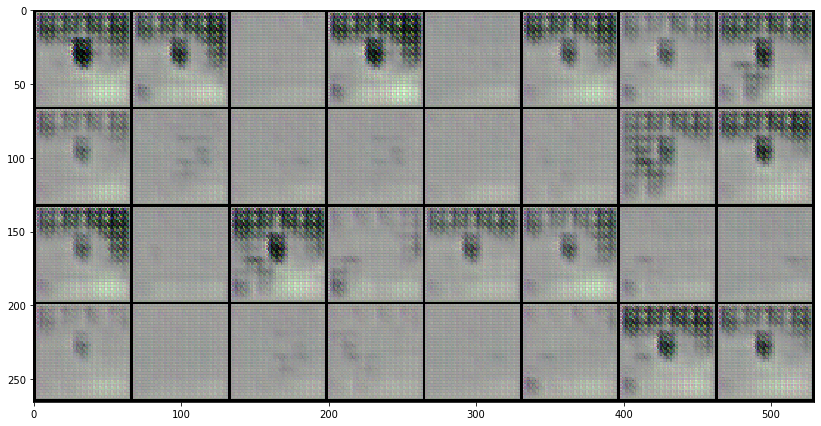

[Epoch 30/100] [D loss: 15.298023] [G loss: 77.040565] [test score: 0.125000]
[Epoch 31/100] [D loss: 12.712979] [G loss: -74.765640] [test score: 0.097222]
[Epoch 32/100] [D loss: 7.217775] [G loss: 46.485244] [test score: 0.138889]
[Epoch 33/100] [D loss: 4.415220] [G loss: 697.557776] [test score: 0.111111]
[Epoch 34/100] [D loss: 11.923412] [G loss: 441.971569] [test score: 0.111111]
[Epoch 35/100] [D loss: -68.388237] [G loss: 884.640405] [test score: 0.125000]
[Epoch 36/100] [D loss: -47.979504] [G loss: 755.402469] [test score: 0.111111]
[Epoch 37/100] [D loss: 37.974439] [G loss: 482.963695] [test score: 0.111111]
[Epoch 38/100] [D loss: 17.855199] [G loss: 439.846288] [test score: 0.111111]
[Epoch 39/100] [D loss: 22.697647] [G loss: -8.556374] [test score: 0.111111]


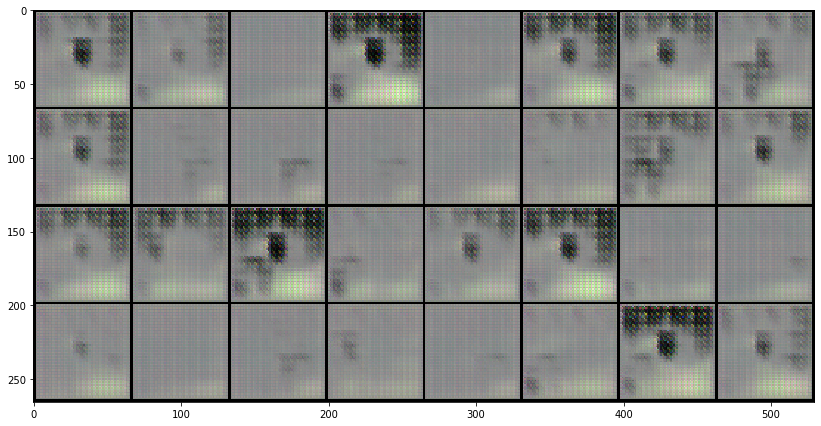

[Epoch 40/100] [D loss: 14.516391] [G loss: -9.035841] [test score: 0.111111]
[Epoch 41/100] [D loss: 5.693282] [G loss: 203.288237] [test score: 0.111111]
[Epoch 42/100] [D loss: 1.469316] [G loss: -379.511623] [test score: 0.125000]
[Epoch 43/100] [D loss: 5.706096] [G loss: 195.932076] [test score: 0.138889]
[Epoch 44/100] [D loss: 2.643498] [G loss: 501.887439] [test score: 0.125000]
[Epoch 45/100] [D loss: 16.756768] [G loss: -110.957418] [test score: 0.125000]
[Epoch 46/100] [D loss: 15.671907] [G loss: 275.704205] [test score: 0.125000]
[Epoch 47/100] [D loss: 17.036162] [G loss: 137.574204] [test score: 0.125000]
[Epoch 48/100] [D loss: 16.038767] [G loss: 115.520942] [test score: 0.125000]
[Epoch 49/100] [D loss: 12.794619] [G loss: 19.824980] [test score: 0.125000]


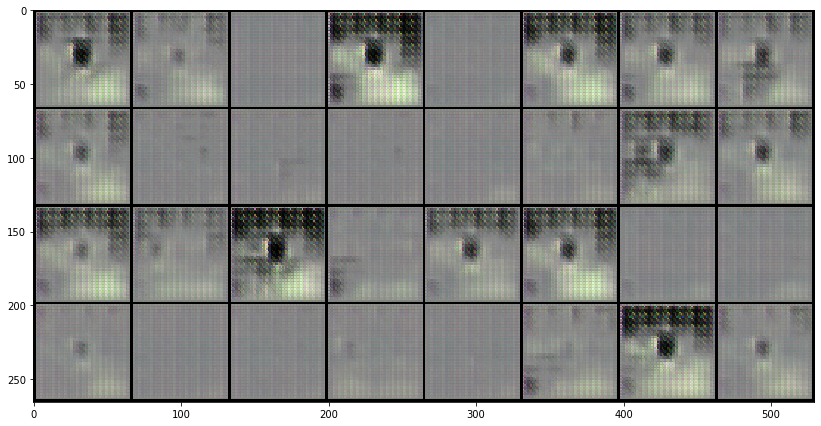

[Epoch 50/100] [D loss: 10.794466] [G loss: 224.128943] [test score: 0.125000]
[Epoch 51/100] [D loss: 11.026262] [G loss: -4.901205] [test score: 0.125000]
[Epoch 52/100] [D loss: 10.839705] [G loss: 164.951637] [test score: 0.111111]
[Epoch 53/100] [D loss: 8.788234] [G loss: 20.731708] [test score: 0.111111]
[Epoch 54/100] [D loss: 7.805511] [G loss: 92.237698] [test score: 0.111111]
[Epoch 55/100] [D loss: 14.587560] [G loss: 129.661625] [test score: 0.097222]
[Epoch 56/100] [D loss: -37.344410] [G loss: 4264.441196] [test score: 0.138889]
[Epoch 57/100] [D loss: -44.119194] [G loss: -2997.948410] [test score: 0.166667]
[Epoch 58/100] [D loss: -58.572224] [G loss: 3423.584718] [test score: 0.125000]
[Epoch 59/100] [D loss: -60.572487] [G loss: 135.927996] [test score: 0.083333]


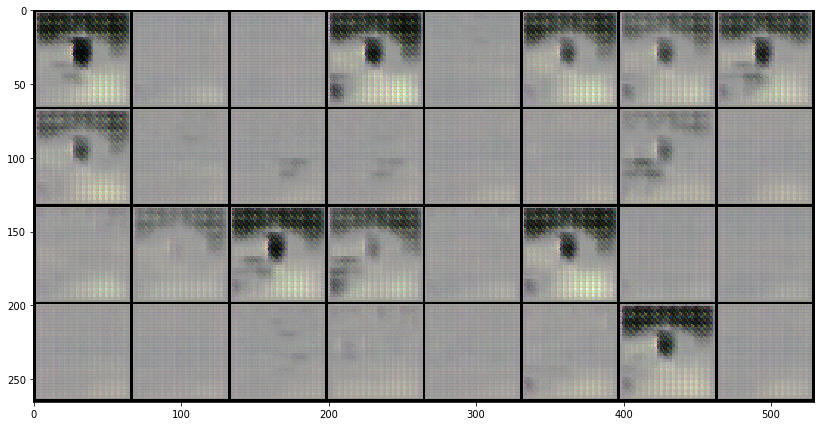

[Epoch 60/100] [D loss: 6.496309] [G loss: -222.535222] [test score: 0.097222]
[Epoch 61/100] [D loss: 14.911433] [G loss: 239.879635] [test score: 0.125000]
[Epoch 62/100] [D loss: 16.993674] [G loss: 464.775326] [test score: 0.097222]
[Epoch 63/100] [D loss: 17.399103] [G loss: -19.270430] [test score: 0.138889]
[Epoch 64/100] [D loss: 13.932434] [G loss: -115.752374] [test score: 0.138889]
[Epoch 65/100] [D loss: 15.954127] [G loss: 74.586367] [test score: 0.125000]
[Epoch 66/100] [D loss: 12.462520] [G loss: 10.847973] [test score: 0.125000]
[Epoch 67/100] [D loss: 10.920687] [G loss: 89.152049] [test score: 0.152778]
[Epoch 68/100] [D loss: 10.849614] [G loss: 42.647261] [test score: 0.152778]
[Epoch 69/100] [D loss: 10.875157] [G loss: 15.091637] [test score: 0.125000]


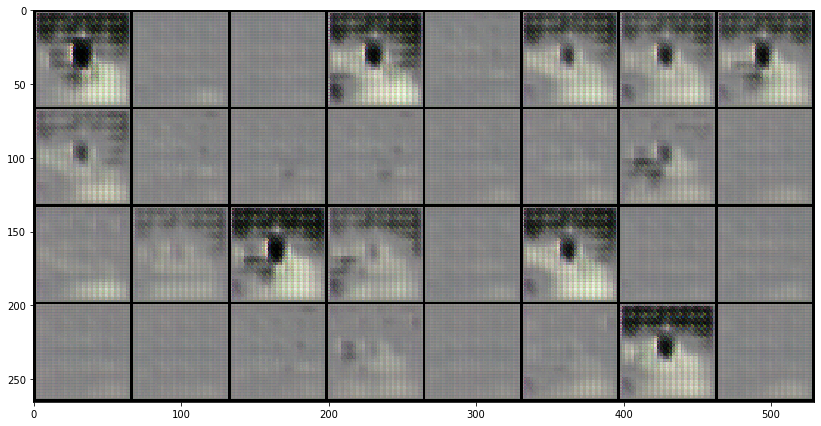

[Epoch 70/100] [D loss: 12.314191] [G loss: 194.702089] [test score: 0.138889]
[Epoch 71/100] [D loss: 9.842068] [G loss: 26.194089] [test score: 0.138889]
[Epoch 72/100] [D loss: 16.182147] [G loss: 88.475622] [test score: 0.125000]
[Epoch 73/100] [D loss: 8.958677] [G loss: 495.035738] [test score: 0.125000]
[Epoch 74/100] [D loss: 3.652872] [G loss: 107.459256] [test score: 0.138889]
[Epoch 75/100] [D loss: 16.856511] [G loss: 311.079922] [test score: 0.125000]
[Epoch 76/100] [D loss: 6.894516] [G loss: -28.851663] [test score: 0.138889]
[Epoch 77/100] [D loss: 15.980232] [G loss: -18.021460] [test score: 0.152778]
[Epoch 78/100] [D loss: 7.370912] [G loss: 334.158519] [test score: 0.125000]
[Epoch 79/100] [D loss: 27.635450] [G loss: 412.218236] [test score: 0.111111]


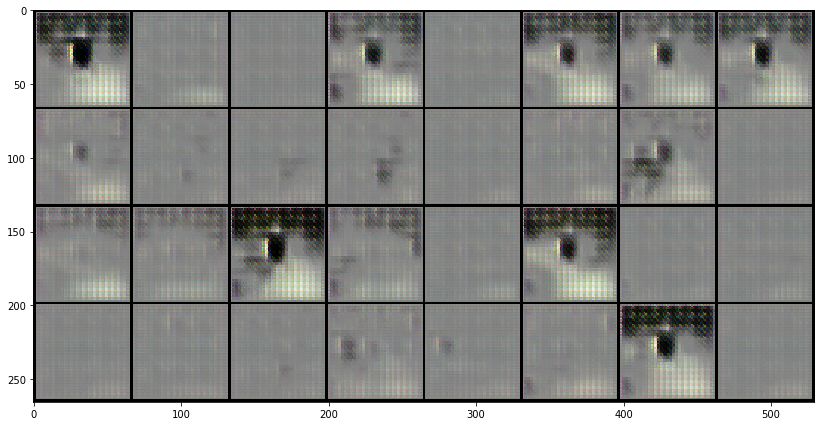

[Epoch 80/100] [D loss: 28.900087] [G loss: 619.423507] [test score: 0.125000]
[Epoch 81/100] [D loss: 28.873524] [G loss: 148.410610] [test score: 0.125000]
[Epoch 82/100] [D loss: 25.001889] [G loss: -116.545365] [test score: 0.125000]
[Epoch 83/100] [D loss: 24.138366] [G loss: 132.373190] [test score: 0.125000]
[Epoch 84/100] [D loss: 23.496828] [G loss: 35.486573] [test score: 0.111111]
[Epoch 85/100] [D loss: 21.006849] [G loss: 33.256310] [test score: 0.125000]
[Epoch 86/100] [D loss: 20.998728] [G loss: -47.560551] [test score: 0.138889]
[Epoch 87/100] [D loss: 17.167818] [G loss: 61.748043] [test score: 0.138889]
[Epoch 88/100] [D loss: 19.063173] [G loss: 122.996930] [test score: 0.138889]
[Epoch 89/100] [D loss: 17.877460] [G loss: 233.208988] [test score: 0.097222]


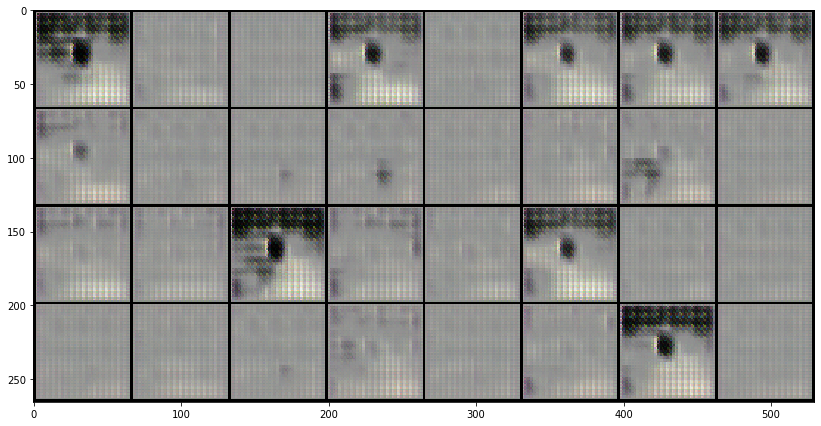

[Epoch 90/100] [D loss: -3.454676] [G loss: 392.367329] [test score: 0.111111]
[Epoch 91/100] [D loss: 66.140886] [G loss: 539.753358] [test score: 0.125000]
[Epoch 92/100] [D loss: 64.615995] [G loss: 110.801070] [test score: 0.125000]
[Epoch 93/100] [D loss: 10.001557] [G loss: -393.829200] [test score: 0.138889]
[Epoch 94/100] [D loss: 0.902746] [G loss: -83.594828] [test score: 0.097222]
[Epoch 95/100] [D loss: -9.469374] [G loss: 569.211033] [test score: 0.097222]
[Epoch 96/100] [D loss: 17.773632] [G loss: 1503.730608] [test score: 0.152778]
[Epoch 97/100] [D loss: -27.921490] [G loss: -858.534396] [test score: 0.097222]
[Epoch 98/100] [D loss: -12.416215] [G loss: 3713.800657] [test score: 0.111111]
[Epoch 99/100] [D loss: -31.002229] [G loss: -2839.473809] [test score: 0.097222]


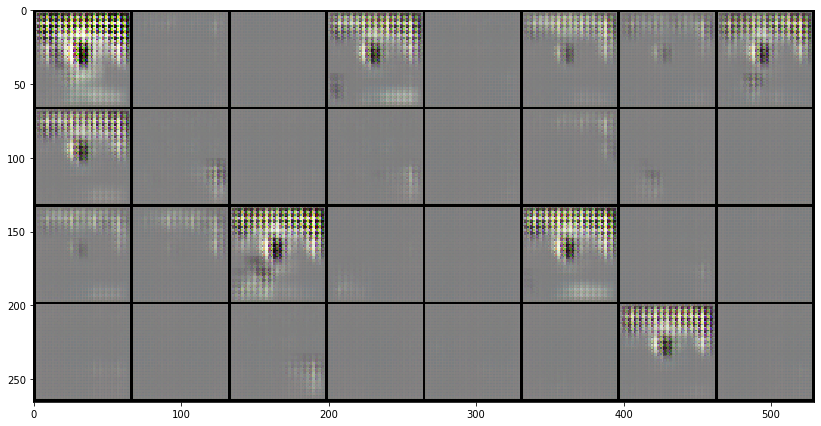

[Epoch 100/100] [D loss: -12.810606] [G loss: 3408.904055] [test score: 0.097222]



In [6]:
# training 
epochs = 100
n_critic = 5 # number of training steps for discriminator per iter
clip_value = 0.01
lambda_cls = 5 # los weight for cls 
save = True
g_loss_list = []
d_loss_list = []
max_g_loss = np.inf
max_d_loss = -np.inf

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    generator.train()
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)
        
        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
#         gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
#         one_hot =  np.zeros((batch_size, n_classes))
#         one_hot[np.arange(batch_size), gen_labels] = 1
#         gen_labels = torch.from_numpy(one_hot).to(device)        
        
        # Generate a batch of images
        gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        for parm in discriminator.parameters():
                parm.data.clamp_(-clip_value, clip_value)
        
        optimizer_D.zero_grad()

         # Real images
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = - torch.mean(real_pred)
        d_real_cls_loss = auxiliary_loss(real_aux, real_labels.float())
                
        # Fake images
        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = torch.mean(fake_pred)
        d_fake_cls_loss = auxiliary_loss(fake_aux, real_labels.float())
        
         # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss + lambda_cls*d_real_cls_loss
        
        
#         print( "   [Epoch %d/%d] [Iter %d/%d] [d_real_loss %f] [d_fake_loss %f] [d_real_cls_loss %f] [d_fake_cls_loss %f]"
#                 % (epoch+1, epochs, i, len(train_loader), d_real_loss, d_fake_loss, d_real_cls_loss, d_fake_cls_loss)
#             )
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Loss measures generator's ability to fool the discriminator
            gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
            
            # Loss measures generator's ability to fool the discriminator
            fake_validity, pred_label = discriminator(gen_imgs)
                        
            g_loss_fake = -torch.mean(fake_validity)
            g_loss_cls = auxiliary_loss(pred_label, real_labels.float())
            g_loss = g_loss_fake + lambda_cls * g_loss_cls
            
            g_loss.backward()
            optimizer_G.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    score = test_eval(generator, epoch+1)
    total_d_loss /= len(train_loader)
    total_g_loss /= (len(train_loader)/n_critic)
    
    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f] [test score: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss, score)
    )

    # loss save
    if save:
        save_acc(path+"loss.npz", total_g_loss, total_d_loss, score)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)
    
    if save:
        if max_g_loss > total_g_loss:
            max_g_loss = total_g_loss
            torch.save(generator, path+"generator.pt")
        if max_d_loss > total_d_loss:
            max_d_loss = total_d_loss
            torch.save(discriminator, path+"discriminator.pt")

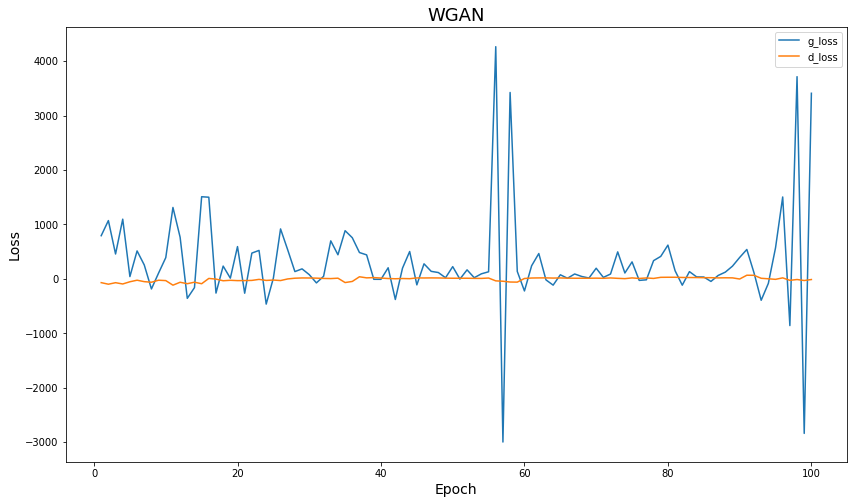

In [9]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load(path+"loss.npz")
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']
    score = acc["score"]

plt.title("WGAN", fontsize=18)
plt.ylabel("Loss", fontsize=14)
# plt.ylabel("Score", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
plt.plot(x, g_loss, label="g_loss")
plt.plot(x, d_loss, label="d_loss")
# plt.plot(x, score, label="test_score")
plt.legend()
plt.show()

In [ ]:
## evaluate
generator_load = torch.load(path+"generator.pt", map_location=device)
# generator_load2 = torch.load(path+"generator_epoch600.pt", map_location=device)
# generator_load.eval()

print(test_eval(generator_load, 0))
# print(test_eval(generator_load2, 0))
print(test_eval(generator, 0))

In [ ]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

In [ ]:
img, label = train.__getitem__(0)
 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))